In [1]:
import timesfm
# For Torch
tfm = timesfm.TimesFm(
      hparams=timesfm.TimesFmHparams(
          backend="gpu",
          per_core_batch_size=32,
          horizon_len=128,
          num_layers=50,
          use_positional_embedding=False,
          context_len=2048,
      ),
      checkpoint=timesfm.TimesFmCheckpoint(
          huggingface_repo_id="google/timesfm-2.0-500m-pytorch"),
  )

 See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.
Loaded PyTorch TimesFM, likely because python version is 3.11.11 (main, Dec 11 2024, 16:28:39) [GCC 11.2.0].


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

In [4]:
import numpy as np
forecast_input = [
    np.sin(np.linspace(0, 20, 100)),
    np.sin(np.linspace(0, 20, 200)),
    np.sin(np.linspace(0, 20, 400)),
]
frequency_input = [0, 1, 2]

point_forecast, experimental_quantile_forecast = tfm.forecast(
    forecast_input,
    freq=frequency_input,
)

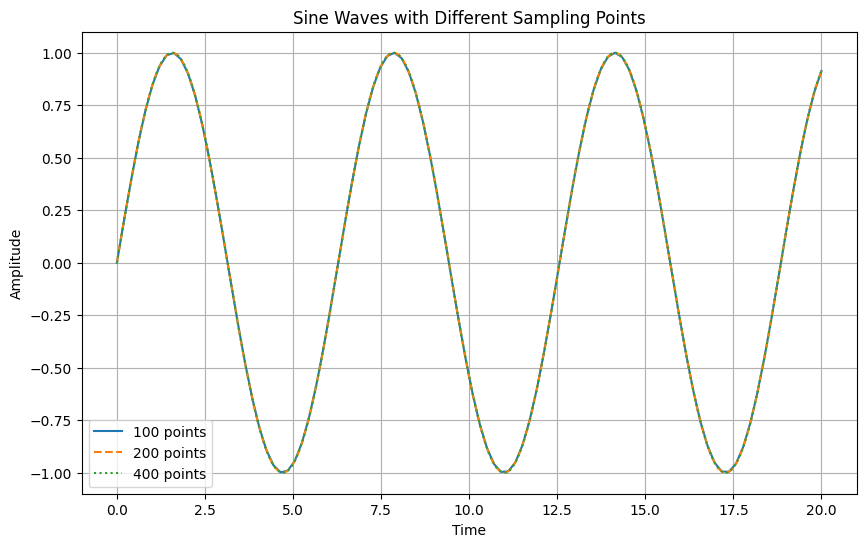

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# 定义数据
forecast_input = [
    np.sin(np.linspace(0, 20, 100)),  # 100 个点
    np.sin(np.linspace(0, 20, 200)),  # 200 个点
    np.sin(np.linspace(0, 20, 400)),  # 400 个点
]

# 创建时间轴（x 轴），长度与每个序列对应
x1 = np.linspace(0, 20, 100)
x2 = np.linspace(0, 20, 200)
x3 = np.linspace(0, 20, 400)

# 绘制图像
plt.figure(figsize=(10, 6))  # 设置图像大小
plt.plot(x1, forecast_input[0], label='100 points', linestyle='-', linewidth=1.5)
plt.plot(x2, forecast_input[1], label='200 points', linestyle='--', linewidth=1.5)
plt.plot(x3, forecast_input[2], label='400 points', linestyle=':', linewidth=1.5)

# 添加标题和标签
plt.title('Sine Waves with Different Sampling Points')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()  # 显示图例
plt.grid(True)  # 添加网格线

# 显示图像
plt.show()

In [16]:
point_forecast[0,:]

array([ 9.83746648e-01,  1.01065469e+00,  1.00325358e+00,  9.46732163e-01,
        8.51728201e-01,  7.23342896e-01,  5.61208069e-01,  3.80572230e-01,
        1.79073617e-01, -2.67258286e-02, -2.32113212e-01, -4.27830309e-01,
       -5.99025488e-01, -7.64771938e-01, -8.78619194e-01, -9.67810512e-01,
       -1.01031470e+00, -1.01604700e+00, -9.84019756e-01, -9.12956119e-01,
       -8.01772118e-01, -6.50981784e-01, -4.71728176e-01, -2.84182340e-01,
       -7.70838559e-02,  1.27240315e-01,  3.29177588e-01,  5.12138724e-01,
        6.82633460e-01,  8.17139626e-01,  9.16527033e-01,  9.84638095e-01,
        1.01296473e+00,  1.00419497e+00,  9.52391863e-01,  8.54743838e-01,
        7.38911331e-01,  5.88088274e-01,  4.05613035e-01,  2.08451942e-01,
       -5.27054071e-04, -2.10887581e-01, -4.13263768e-01, -6.05156541e-01,
       -7.68680453e-01, -8.80225539e-01, -9.74400163e-01, -1.02037776e+00,
       -1.02086830e+00, -9.88066316e-01, -9.13965940e-01, -8.08942795e-01,
       -6.66439414e-01, -

In [15]:
experimental_quantile_forecast[0,:,5]

array([ 9.83746648e-01,  1.01065469e+00,  1.00325358e+00,  9.46732163e-01,
        8.51728201e-01,  7.23342896e-01,  5.61208069e-01,  3.80572230e-01,
        1.79073617e-01, -2.67258286e-02, -2.32113212e-01, -4.27830309e-01,
       -5.99025488e-01, -7.64771938e-01, -8.78619194e-01, -9.67810512e-01,
       -1.01031470e+00, -1.01604700e+00, -9.84019756e-01, -9.12956119e-01,
       -8.01772118e-01, -6.50981784e-01, -4.71728176e-01, -2.84182340e-01,
       -7.70838559e-02,  1.27240315e-01,  3.29177588e-01,  5.12138724e-01,
        6.82633460e-01,  8.17139626e-01,  9.16527033e-01,  9.84638095e-01,
        1.01296473e+00,  1.00419497e+00,  9.52391863e-01,  8.54743838e-01,
        7.38911331e-01,  5.88088274e-01,  4.05613035e-01,  2.08451942e-01,
       -5.27054071e-04, -2.10887581e-01, -4.13263768e-01, -6.05156541e-01,
       -7.68680453e-01, -8.80225539e-01, -9.74400163e-01, -1.02037776e+00,
       -1.02086830e+00, -9.88066316e-01, -9.13965940e-01, -8.08942795e-01,
       -6.66439414e-01, -

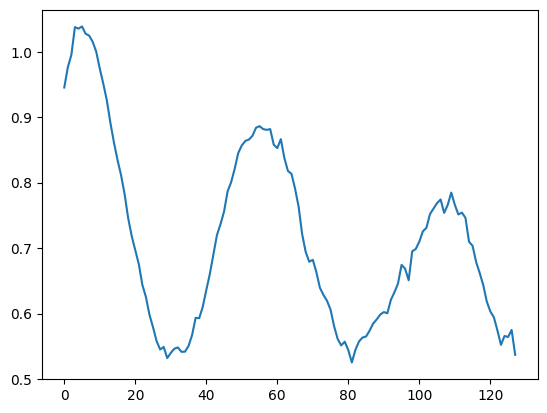

In [10]:
import matplotlib.pyplot as plt

plt.plot(point_forecast[1])

In [3]:
point_forecast
#把point_forecast 转置
#point_forecast = point_forecast.transpose(1,0)

array([[ 9.83746648e-01,  1.01065469e+00,  1.00325358e+00,
         9.46732163e-01,  8.51728201e-01,  7.23342896e-01,
         5.61208069e-01,  3.80572230e-01,  1.79073617e-01,
        -2.67258286e-02, -2.32113212e-01, -4.27830309e-01,
        -5.99025488e-01, -7.64771938e-01, -8.78619194e-01,
        -9.67810512e-01, -1.01031470e+00, -1.01604700e+00,
        -9.84019756e-01, -9.12956119e-01, -8.01772118e-01,
        -6.50981784e-01, -4.71728176e-01, -2.84182340e-01,
        -7.70838559e-02,  1.27240315e-01,  3.29177588e-01,
         5.12138724e-01,  6.82633460e-01,  8.17139626e-01,
         9.16527033e-01,  9.84638095e-01,  1.01296473e+00,
         1.00419497e+00,  9.52391863e-01,  8.54743838e-01,
         7.38911331e-01,  5.88088274e-01,  4.05613035e-01,
         2.08451942e-01, -5.27054071e-04, -2.10887581e-01,
        -4.13263768e-01, -6.05156541e-01, -7.68680453e-01,
        -8.80225539e-01, -9.74400163e-01, -1.02037776e+00,
        -1.02086830e+00, -9.88066316e-01, -9.13965940e-0

In [1]:
import torch
# 生成一个随机的三维张量
tensor = torch.randn(3, 4, 5)
print(tensor)

tensor([[[ 0.2348, -0.2109,  0.1506, -0.4710,  0.5839],
         [-0.5979,  0.3627,  0.4447, -0.4865, -0.1916],
         [ 0.5814, -1.5179, -0.4721,  0.8426,  0.5490],
         [-0.7890, -1.1598,  0.9888,  0.3396, -0.5635]],

        [[ 0.8737,  0.4748,  1.3407,  0.3698, -1.1591],
         [-0.2828,  0.3396,  0.1902,  0.8115,  0.5415],
         [ 1.7190, -0.2857,  1.4118, -0.4681, -0.3718],
         [ 0.1811, -0.3050, -0.6368,  0.4683, -1.7901]],

        [[-1.2574, -1.6281,  0.8842, -0.2971, -0.9057],
         [-0.7821, -0.0093, -0.7212,  0.8943, -1.3309],
         [ 1.9223, -0.6249,  0.6259,  0.5890, -1.8432],
         [-2.2552, -0.4227,  0.0891, -0.2288, -0.5557]]])


In [2]:
tensor[:,:,0:2]

tensor([[[ 0.2348, -0.2109],
         [-0.5979,  0.3627],
         [ 0.5814, -1.5179],
         [-0.7890, -1.1598]],

        [[ 0.8737,  0.4748],
         [-0.2828,  0.3396],
         [ 1.7190, -0.2857],
         [ 0.1811, -0.3050]],

        [[-1.2574, -1.6281],
         [-0.7821, -0.0093],
         [ 1.9223, -0.6249],
         [-2.2552, -0.4227]]])